In [1]:
import sys
sys.path.append("/home/tinkerer/spin-qubit/codes/")
sys.path.insert(0, "/home/tinkerer/Poisson_Solver/")

import numpy as np
from collections import OrderedDict
from ccode.plotting import plot_gates
from scipy import constants

from Hamiltonian import discrete_system_coordinates, kwant_system, tight_binding_Hamiltonian
from potential import gate_potential, linear_problem_instance
from utility import prepare_voltages
from plotting import plot_potential
from layout import (
    Layout,
    OverlappingGateLayer,
    PlanarGateLayer,
    SimpleChargeLayer,
    SimpleVoltageLayer,
    TwoDEGLayer,
)

VoronoiMesh version 0.1
DiscretePoisson version 0.3
Shape version: 0.1
SystEquations version: 0.3
Solver version 0.1


In [137]:
a = 1

In [132]:
# Functions used to create the vertices

def rectangular_gate(center, length, width): 
    """
    Returns vertices of a gate
    """
    x, y = center

    gate = np.array(
        [
            [-width/2, -length/2],
            [-width/2, length/2],
            [width/2, length/2],
            [width/2, -length/2]
        ]
    )
    gate[:, 0] += x
    gate[:, 1] += y

    return gate


def half_disk_gate(R, center=(0, 0), npts=100, shift=0):
    """
    Return vertices of a half disk shaped polygon
    """
    x, y = center

    angles = np.linspace(0, np.pi, npts)

    xs = x + np.cos(angles)*R
    ys = y + np.sin(angles)*R
    
    ys[0] -= shift
    ys[-1] -= shift

    return np.vstack([xs, ys]).T


def ring_gate(R, r, center=(0, 0), npts=100):
    """
    Return vertices of a ring-shaped polygon
    Parameters:
    -----------
        R: outer radius
        r: inner radius
    """
    x, y = center

    angles = np.linspace(0, np.pi, npts)

    Xs = x + np.cos(angles)*R
    Ys = y + np.sin(angles)*R

    xs = x + np.cos(angles)*r
    ys = y + np.sin(angles)*r

    out_ring = np.vstack([Xs, Ys]).T
    in_ring = np.vstack([xs, ys]).T[::-1]

    return np.vstack([out_ring, in_ring])

def covering_ring(center=(0, 0), npts=100):
    """
    Return vertices of a polygon that completes a rectangular region with an internal disk
    """
    angles = np.linspace(0, np.pi/2, npts)
    x, y = center
    Xs = x + np.cos(angles)*(R+gap)
    Ys = y + np.sin(angles)*(R+gap)
    where_cut = np.where(np.abs(Xs - gap - wire_width/2) < 1)[0]
    Xs = Xs[:where_cut[0]]
    Ys = Ys[:where_cut[0]]

    borders = [
        [Xs[-1], R + gap +tunel_length + y],
        [R + 2*gap + 2*wire_width, R + gap +tunel_length + y],
        [R + 2*gap + 2*wire_width, 0],
        [Xs[0], 0]
    ]
    vertex = np.vstack([np.concatenate((Xs, np.array(borders)[:, 0])), np.concatenate((Ys, np.array(borders)[:, 1]))]).T
    return vertex

In [133]:
# Geometry parameters
R = 100
wire_width = 15
r = R-15
gap = 8
tunel_length = 5
y_shift = tunel_length + gap

In [145]:
# Boundaries within Poisson region
zmin = -0.5
zmax = 0.5
xmax = R + 2*gap + 2*wire_width
xmin = -xmax
ymin = 0
ymax = R + gap +tunel_length + y_shift
boundaries = [xmin, xmax, ymin, ymax, zmin, zmax]
total_width = 2*xmax
total_length = ymax

In [140]:
screen_gates = {}
screen_gates['disk_screen'] = half_disk_gate(R=r-gap, center=(0, y_shift), shift=gap+tunel_length)
screen_gates['extra_screen_right'] = covering_ring(center=(0, y_shift))
reflected_extra_screen = covering_ring(center=(0, y_shift))
reflected_extra_screen[:, 0] *= -1
screen_gates['extra_screen_left'] = reflected_extra_screen

plunger_gates = {}

x_c_P = R-wire_width/2
y_c = tunel_length/2
width_P = R - 3/2 * wire_width - 2 * gap

plunger_gates['ring_plunger'] = ring_gate(R=R, r=r, center=(0, y_shift))

tunel_gates = {}
x_c_T = R - wire_width/2
tunel_gates['left_tunel'] = rectangular_gate(center=(-x_c_T, y_c), length=tunel_length, width=wire_width)
tunel_gates['central_tunel'] = rectangular_gate(center=(0, R + 2 * gap + y_c + 5), length=tunel_length, width=wire_width)
tunel_gates['right_tunel'] = rectangular_gate(center=(x_c_T, y_c), length=tunel_length, width=wire_width)

In [141]:
gates = {'plunger_gates': plunger_gates, 'screen_gates': screen_gates, 'tunel_gates': tunel_gates}

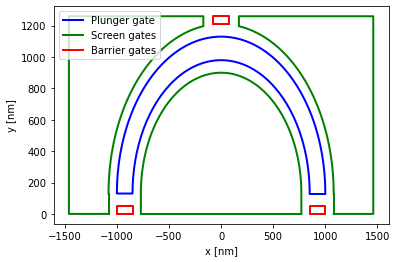

In [142]:
plot_gates(gates);

In [146]:
# Set up system paramters
thickness_barrier = 4
thickness_twoDEG = 4
thickness_gates = 6
thickness_self_Al2O3 = 4

meff = 0.023 * constants.m_e  # in Kg
eV = 1.0
bandgap_GaAs = 1.519 * eV

permittivity_metal = 5000
permittivity_GaAs = 12.18
permittivity_twoDEG = 15  # InAs
permittivity_air = 1.0
permittivity_Al2O3 = 9.1

grid_spacing_twoDEG = 1
grid_spacing_normal = 1
grid_spacing_dielectric = 5
grid_spacing_air = 5
grid_spacing_GaAs = grid_spacing_normal
grid_spacing_gate = grid_spacing_twoDEG
grid_spacing = grid_spacing_twoDEG

In [147]:
# Solve for Poisson system
layout = Layout(total_width,
                total_length,
                grid_width_air=grid_spacing_air,
                margin=(50, 50, 50),
                shift=(0, total_length/2, 0))

layout.add_layer(
    TwoDEGLayer(
        "twoDEG",
        thickness_twoDEG,
        permittivity_twoDEG,
        grid_spacing_twoDEG
    ),
    center=True,
)

layout.add_layer(
    SimpleChargeLayer(
        "GaAs",
        thickness_barrier,
        permittivity_Al2O3,
        grid_spacing_GaAs,
    )
)

vertex = (
    list(gates["plunger_gates"].values()),
    list(gates["screen_gates"].values()),
    list(gates["tunel_gates"].values()),
        )

layout.add_layer(
    OverlappingGateLayer(
        vertex,
        np.hstack([list(gates[key].keys()) for key, _ in gates.items()]),
        thickness_gates,
        thickness_self_Al2O3,
        permittivity_metal,
        grid_spacing_gate,
    )
)

poisson_system = layout.build()
linear_problem = linear_problem_instance(poisson_system)



------------------------------------------------






------------------------------------------------






------------------------------------------------






/home/tinkerer/Poisson_Solver/poisson/continuous/geometry.py:68: RuntimeWarning:  
 
 voltage functions are not well defined.
 Their intersection is not empty. 
 Check poisson.system.System or poisson.geometry.Geometry class attribute 
 sub_regions_intersection for a list of the index of the points belonging to 
 the intersection 
 
  warnings.warn(warning_message, RuntimeWarning)


AssertionError: Error: there are overlapping regions.